# Automatic Music Generation

### Importing the libraries

In [1]:
from music21 import *
import os
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
import random
from keras.models import load_model
from sklearn.model_selection import train_test_split
from google.colab import files

### Loading the MIDI files

In [2]:
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)
    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
          notes_to_parse = part.recurse() 
          #finding whether a particular element is note or a chord
          for element in notes_to_parse:
            if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
            elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [3]:
#specify the path
path='/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])


Loading Music File: /midi_songs_Cids.mid
Loading Music File: /midi_songs_traitor.mid
Loading Music File: /midi_songs_Ff4-BattleLust.mid
Loading Music File: /midi_songs_ultros.mid
Loading Music File: /midi_songs_Final_Fantasy_7_-_Judgement_Day_Piano.mid
Loading Music File: /midi_songs_ff4-town.mid
Loading Music File: /midi_songs_Final_Fantasy_Matouyas_Cave_Piano.mid
Loading Music File: /midi_songs_Gold_Silver_Rival_Battle.mid
Loading Music File: /midi_songs_In_Zanarkand.mid
Loading Music File: /midi_songs_Life_Stream.mid
Loading Music File: /midi_songs_goldsaucer.mid
Loading Music File: /midi_songs_Rydia_pc.mid
Loading Music File: /midi_songs_FF3_Battle_(Piano).mid
Loading Music File: /midi_songs_FFIII_Edgar_And_Sabin_Piano.mid
Loading Music File: /midi_songs_thenightmarebegins.mid
Loading Music File: /midi_songs_tifap.mid
Loading Music File: /midi_songs_FF4.mid
Loading Music File: /midi_songs_FF3_Third_Phase_Final_(Piano).mid


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


### Understanding the data

In [4]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

227


Looking at the distribution of notes

(array([166.,  13.,   9.,   9.,  14.,  10.,   3.,   1.,   0.,   2.]),
 array([  1. ,  42.7,  84.4, 126.1, 167.8, 209.5, 251.2, 292.9, 334.6,
        376.3, 418. ]),
 <a list of 10 Patch objects>)

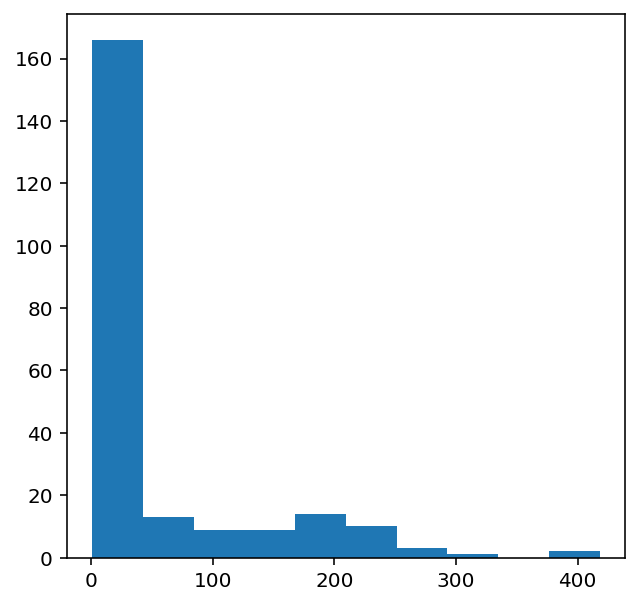

In [5]:
#computing frequency of each note
freq = dict(Counter(notes_))

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

Since there are a lot of low frequency notes we remove them using the condition frequency > 50. It can be changed as per required.

In [6]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

56


In [7]:
# New file with filtered notes
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


### Preparing the data

In [8]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [9]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [10]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [11]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

Train test split - 80/20

In [12]:
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

### Model Building

Model following Wavenet architecture

In [13]:
K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())

model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           5600      
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            19264     
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0         
                                                        

In [14]:
# Saving only the best model using callback
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [15]:
# Training the model with 50 epochs and batch size 128
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,
                    epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

Epoch 1/50
56/57 [============================>.] - ETA: 0s - loss: 3.8874
Epoch 00001: val_loss improved from inf to 3.78083, saving model to best_model.h5
57/57 [==============================] - 11s 149ms/step - loss: 3.8870 - val_loss: 3.7808
Epoch 2/50
56/57 [============================>.] - ETA: 0s - loss: 3.6225
Epoch 00002: val_loss improved from 3.78083 to 3.52027, saving model to best_model.h5
57/57 [==============================] - 5s 85ms/step - loss: 3.6220 - val_loss: 3.5203
Epoch 3/50
56/57 [============================>.] - ETA: 0s - loss: 3.3494
Epoch 00003: val_loss improved from 3.52027 to 3.36373, saving model to best_model.h5
57/57 [==============================] - 5s 85ms/step - loss: 3.3482 - val_loss: 3.3637
Epoch 4/50
56/57 [============================>.] - ETA: 0s - loss: 3.1874
Epoch 00004: val_loss improved from 3.36373 to 3.27956, saving model to best_model.h5
57/57 [==============================] - 5s 87ms/step - loss: 3.1857 - val_loss: 3.2796
Epoch 

In [16]:
#loading best model
model = load_model('best_model.h5')

Generating own music using the model

In [17]:
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

[2, 48, 11, 2, 28, 6, 2, 48, 6, 2]


Converting integers back to notes

In [18]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

Finally converting the notes back to midi file and downloading the generated music

In [23]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    out_file = midi_stream.write('midi', fp='music.mid')
    midi_stream.show('midi')

In [24]:
convert_to_midi(predicted_notes)